# Prepare
## Dataset loading

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
train_raw = pd.read_excel('/home/competition/data/data/ai_competition_train.xlsx')
test_raw = pd.read_excel('/home/competition/data/data/ai_competition_test.xlsx')

train = np.array(train_raw['flux'])
test = np.array(test_raw['flux'])

print(train.shape, test.shape)

(5479,) (60,)


## Nan -> zero (Only train)

In [215]:
# NaN 값을 0.0으로 대체
nan_indices = np.isnan(train)
_mask = np.zeros(len(train))
train[nan_indices] = _mask[nan_indices]

# NaN 값을 대체한 결과 확인
print(train)
print(np.mean(train))
print("NaN 값의 개수:", np.sum(np.isnan(test)))


[ 94.8    96.93   97.71  ...   0.    128.634 143.651]
78.29537461215551
NaN 값의 개수: 0


## Cut zero (Only train)

In [216]:
train_cut = train[train != 0]
print(train_cut.shape)
print(np.mean(train_cut))

(4228,)
101.46176856669818


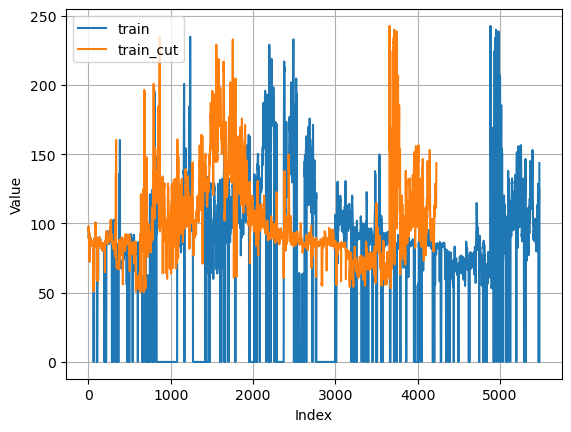

In [217]:
plt.figure()
plt.plot(train, label='train')
plt.plot(train_cut, label='train_cut')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Subtract Mean

In [218]:
train_cut_sub_mean = train_cut - np.mean(train_cut)
print(np.mean(train_cut_sub_mean), np.var(train_cut_sub_mean))

test_mean = np.mean(test)
test_sub_mean = test - test_mean
print(np.mean(test_sub_mean), np.var(test_sub_mean))


1.118583833779382e-14 926.6917847239334
1.4210854715202004e-14 234.5757282247222


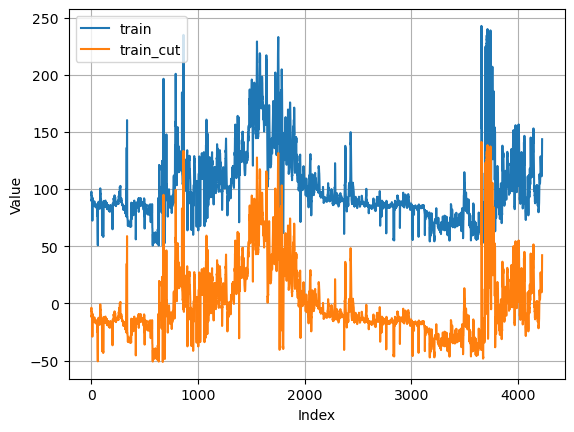

In [219]:
plt.figure()
plt.plot(train_cut, label='train')
plt.plot(train_cut_sub_mean, label='train_cut')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


## Make dataset

In [220]:
INPUT_DAYS = 60

train_x = np.empty([INPUT_DAYS, 1])
train_y = np.empty([1, 1])

print("x and y shape :", train_x.shape, train_y.shape)
for i in range(len(train_cut_sub_mean) - INPUT_DAYS - 1):
    train_x = np.concatenate(
        (train_x, train_cut_sub_mean[i:i+INPUT_DAYS, np.newaxis]), axis=1)
    train_y = np.concatenate(
        (train_y, train_cut_sub_mean[np.newaxis, i+INPUT_DAYS+1, np.newaxis]), axis=1)

print("x and y shape :", train_x.shape, train_y.shape)

train_x = train_x.T
train_y = train_y.T
print("x and y shape :", train_x.shape, train_y.shape)


x and y shape : (60, 1) (1, 1)
x and y shape : (60, 4168) (1, 4168)
x and y shape : (4168, 60) (4168, 1)


# Model

In [221]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, input_shape=(INPUT_DAYS, 1)))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [223]:
loss_history = []
rmse_history = []

class RMSECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        rmse_history.append(tf.sqrt(logs['loss']))


class LossHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss_history.append(logs['loss'])

rmse_callback = RMSECallback()
loss_callback = LossHistory()


In [265]:
model.fit(train_x, train_y, epochs=50, batch_size=256,
          callbacks=[rmse_callback, loss_callback])


Epoch 1/50
17/17 [==============================] - 1s 31ms/step - loss: 261.0300
Epoch 2/50
17/17 [==============================] - 1s 32ms/step - loss: 258.2636
Epoch 3/50
17/17 [==============================] - 1s 36ms/step - loss: 255.7658
Epoch 4/50
17/17 [==============================] - 1s 37ms/step - loss: 252.5757
Epoch 5/50
17/17 [==============================] - 1s 38ms/step - loss: 249.2954
Epoch 6/50
17/17 [==============================] - 1s 34ms/step - loss: 246.8630
Epoch 7/50
17/17 [==============================] - 1s 36ms/step - loss: 244.7364
Epoch 8/50
17/17 [==============================] - 1s 39ms/step - loss: 242.3152
Epoch 9/50
17/17 [==============================] - 1s 39ms/step - loss: 239.6342
Epoch 10/50
17/17 [==============================] - 1s 39ms/step - loss: 236.9979
Epoch 11/50
17/17 [==============================] - 1s 39ms/step - loss: 234.9219
Epoch 12/50
17/17 [==============================] - 1s 38ms/step - loss: 233.8637
Epoch 13/50
1

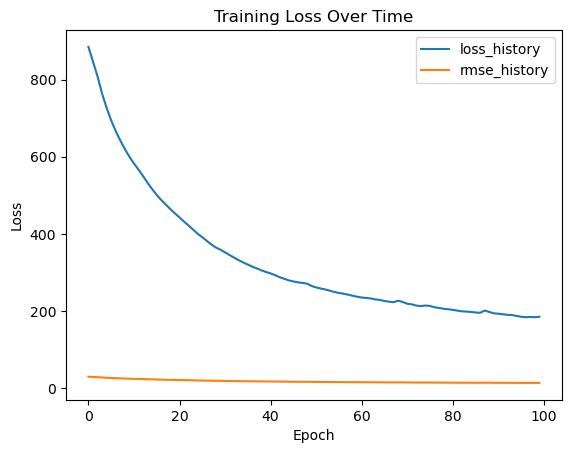

RMSE : tf.Tensor(13.60309, shape=(), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=29.74172>, <tf.Tensor: shape=(), dtype=float32, numpy=29.092464>, <tf.Tensor: shape=(), dtype=float32, numpy=28.424953>, <tf.Tensor: shape=(), dtype=float32, numpy=27.626266>, <tf.Tensor: shape=(), dtype=float32, numpy=26.95059>, <tf.Tensor: shape=(), dtype=float32, numpy=26.339092>, <tf.Tensor: shape=(), dtype=float32, numpy=25.806002>, <tf.Tensor: shape=(), dtype=float32, numpy=25.337423>, <tf.Tensor: shape=(), dtype=float32, numpy=24.890917>, <tf.Tensor: shape=(), dtype=float32, numpy=24.491854>, <tf.Tensor: shape=(), dtype=float32, numpy=24.129675>, <tf.Tensor: shape=(), dtype=float32, numpy=23.799248>, <tf.Tensor: shape=(), dtype=float32, numpy=23.44468>, <tf.Tensor: shape=(), dtype=float32, numpy=23.059427>, <tf.Tensor: shape=(), dtype=float32, numpy=22.713936>, <tf.Tensor: shape=(), dtype=float32, numpy=22.374626>, <tf.Tensor: shape=(), dtype=float32, numpy=22.081305>, <tf.Tensor: sha

In [266]:

plt.plot(loss_history)
plt.plot(rmse_history)
plt.title('Training Loss Over Time')
plt.legend(['loss_history', 'rmse_history'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print("RMSE :", rmse_history[-1])
print(rmse_history)

In [267]:
final_result = test_sub_mean
print(final_result.shape)
for i in range(30):
    
    _single_output = model(
        final_result[np.newaxis, i:i+INPUT_DAYS, np.newaxis]).numpy()
    final_result = np.concatenate((final_result, _single_output[0]), axis=0)
    print(i, final_result.shape, final_result[-1])
    


(60,)
0 (61,) -11.883018493652344
1 (62,) -14.966449737548828
2 (63,) -17.54869270324707
3 (64,) -20.95909309387207
4 (65,) -23.80789566040039
5 (66,) -25.14448356628418
6 (67,) -25.16657066345215
7 (68,) -22.859376907348633
8 (69,) -17.884824752807617
9 (70,) -10.880115509033203
10 (71,) -2.95338773727417
11 (72,) 6.964698791503906
12 (73,) 15.62903881072998
13 (74,) 23.284574508666992
14 (75,) 29.885812759399414
15 (76,) 29.600467681884766
16 (77,) 24.79318618774414
17 (78,) 20.262939453125
18 (79,) 14.147140502929688
19 (80,) 6.602903842926025
20 (81,) -0.2162919044494629
21 (82,) -5.953327178955078
22 (83,) -10.350234031677246
23 (84,) -14.064213752746582
24 (85,) -14.867521286010742
25 (86,) -13.146723747253418
26 (87,) -10.617624282836914
27 (88,) -7.38516902923584
28 (89,) -2.012845516204834
29 (90,) 4.287219524383545


In [268]:
_summit = final_result[-30:]
print(_summit.shape)
print(_summit)

(30,)
[-11.88301849 -14.96644974 -17.5486927  -20.95909309 -23.80789566
 -25.14448357 -25.16657066 -22.85937691 -17.88482475 -10.88011551
  -2.95338774   6.96469879  15.62903881  23.28457451  29.88581276
  29.60046768  24.79318619  20.26293945  14.1471405    6.60290384
  -0.2162919   -5.95332718 -10.35023403 -14.06421375 -14.86752129
 -13.14672375 -10.61762428  -7.38516903  -2.01284552   4.28721952]


In [269]:


# 주어진 벡터 데이터
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
        11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

# 데이터를 Pandas DataFrame으로 변환
df = pd.DataFrame({'date': data, 'flux': _summit})

# DataFrame을 엑셀 파일로 내보내기
df.to_excel('output.xlsx', index=False)
